In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

/Users/yaoyuan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
%matplotlib notebook

In [2]:
mnist = input_data.read_data_sets('../../MNIST_data',one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
n_way = 5
n_shot = 64
mb_size = 1*n_shot
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
n_data = mnist.train.images.shape[0]
h_dim = 128
cnt = 0
lr = 1e-3

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps
    #return mu + eps*log_var
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [5]:
train_images = mnist.train.images
train_labels = mnist.train.labels

img,lab = [[] for _ in range(10)],[[] for _ in range(10)]
for i in range(n_data):
    index = train_labels[i].tolist().index(1)
    img[index].append(train_images[i])
    lab[index].append(train_labels[i])
for i in range(len(img)):
    img[i] = np.asarray(img[i])
    lab[i] = np.asarray(lab[i])


Iter-0; Loss: 113.7
now generating imgae with 4


<IPython.core.display.Javascript object>


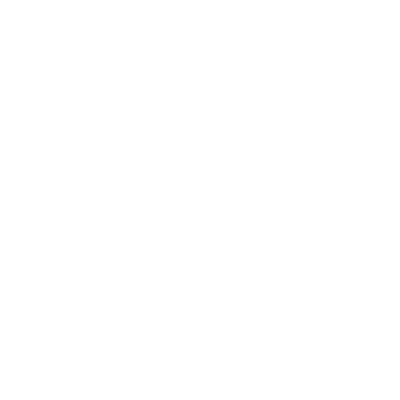

Iter-500; Loss: 107.7
now generating imgae with 4


<IPython.core.display.Javascript object>


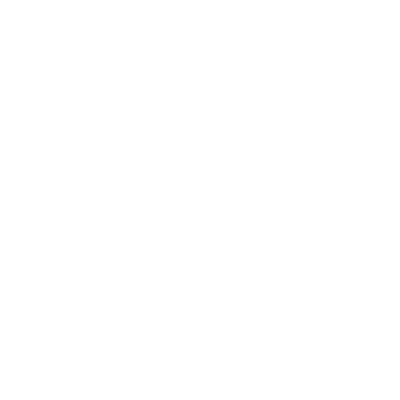

Iter-1000; Loss: 101.2
now generating imgae with 8


<IPython.core.display.Javascript object>


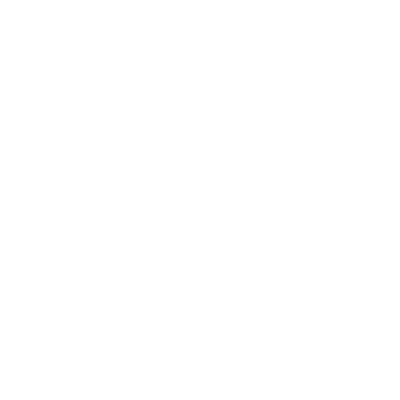

Iter-1500; Loss: 102.6
now generating imgae with 6


<IPython.core.display.Javascript object>


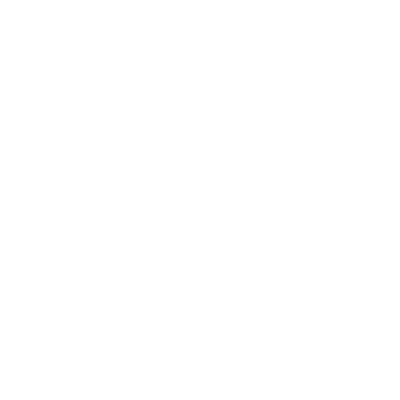

Iter-2000; Loss: 106.3
now generating imgae with 2


<IPython.core.display.Javascript object>


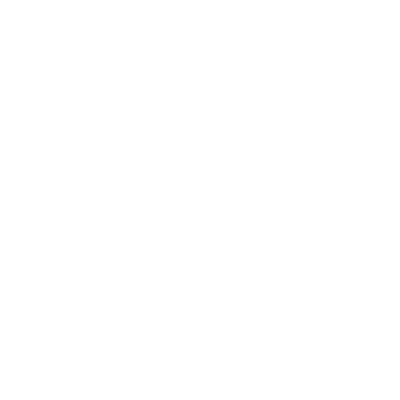

Iter-2500; Loss: 110.0
now generating imgae with 8


<IPython.core.display.Javascript object>


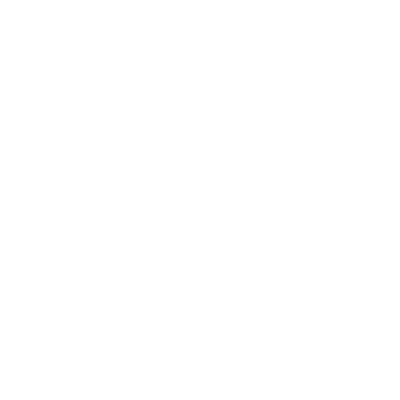

Iter-3000; Loss: 110.7
now generating imgae with 6


<IPython.core.display.Javascript object>


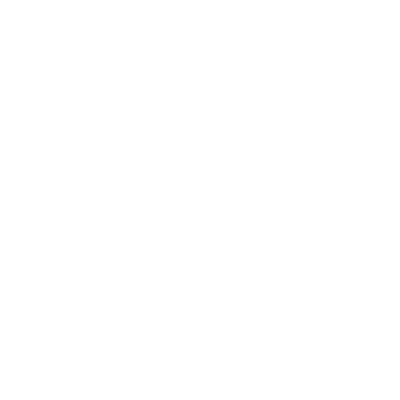

Iter-3500; Loss: 104.1
now generating imgae with 9


<IPython.core.display.Javascript object>


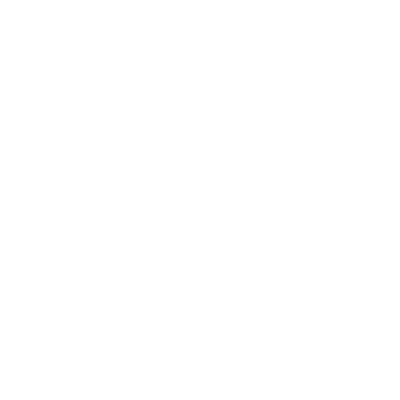

Iter-4000; Loss: 112.2
now generating imgae with 1


<IPython.core.display.Javascript object>


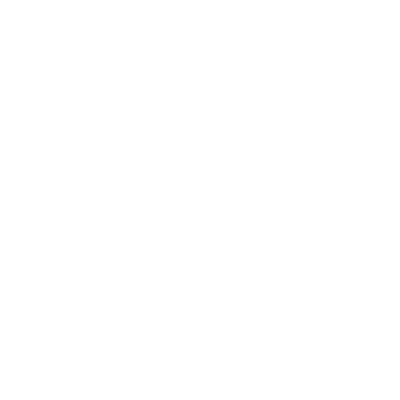

Iter-4500; Loss: 103.7
now generating imgae with 1


<IPython.core.display.Javascript object>


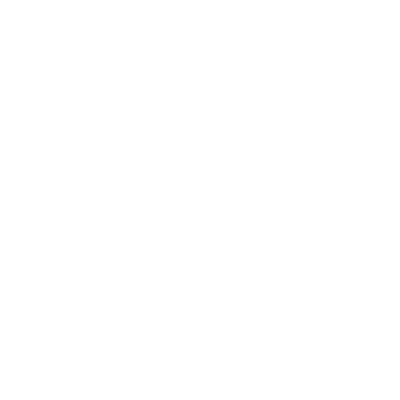

Iter-5000; Loss: 105.7
now generating imgae with 4


<IPython.core.display.Javascript object>


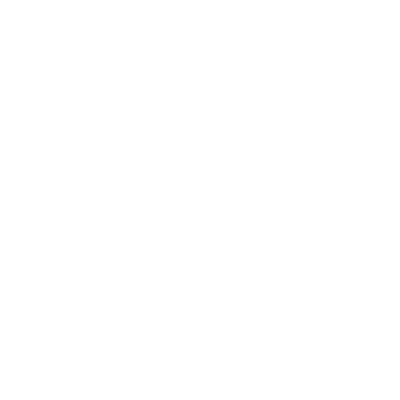

Iter-5500; Loss: 103.9
now generating imgae with 5


<IPython.core.display.Javascript object>


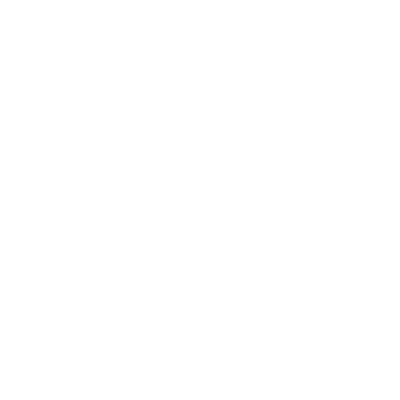

Iter-6000; Loss: 103.3
now generating imgae with 3


<IPython.core.display.Javascript object>


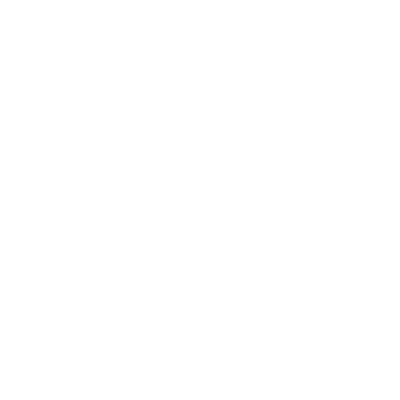

Iter-6500; Loss: 107.0
now generating imgae with 9


<IPython.core.display.Javascript object>


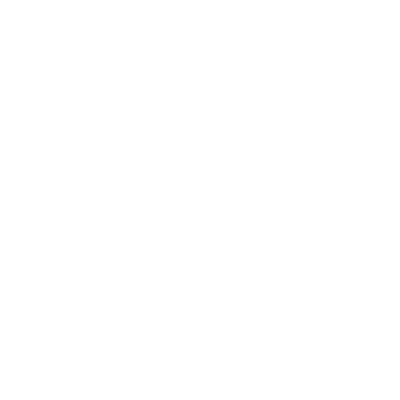

Iter-7000; Loss: 99.22
now generating imgae with 4


<IPython.core.display.Javascript object>


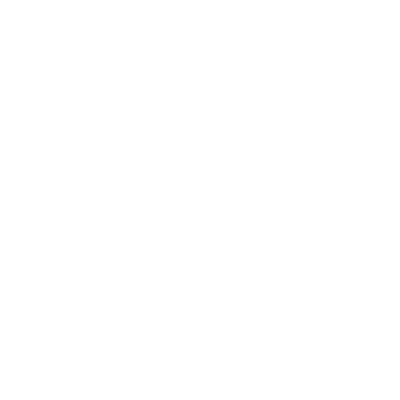

Iter-7500; Loss: 104.7
now generating imgae with 7


<IPython.core.display.Javascript object>


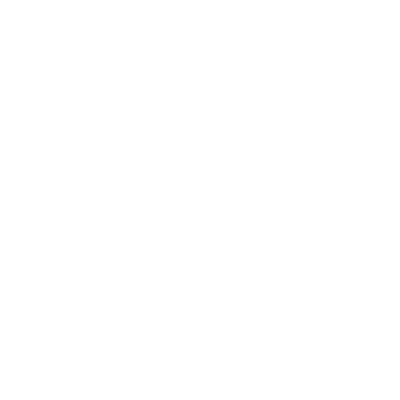

Iter-8000; Loss: 106.1
now generating imgae with 5


<IPython.core.display.Javascript object>


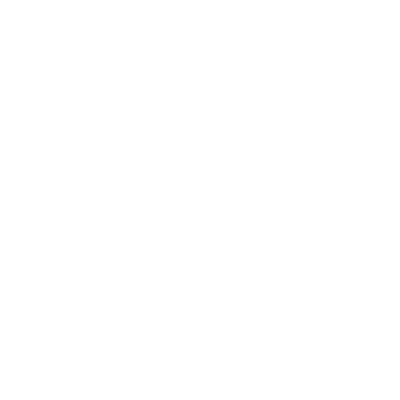

Iter-8500; Loss: 105.5
now generating imgae with 1


<IPython.core.display.Javascript object>


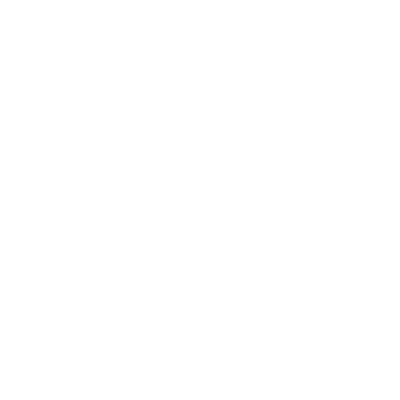

Iter-9000; Loss: 103.0
now generating imgae with 2


<IPython.core.display.Javascript object>


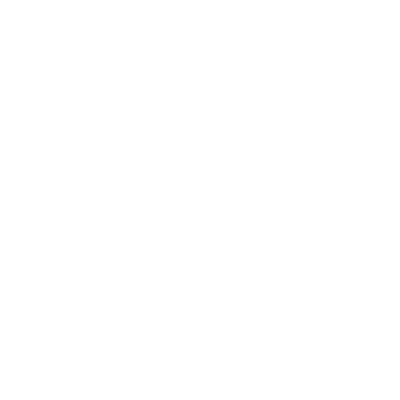

Iter-9500; Loss: 101.8
now generating imgae with 9


<IPython.core.display.Javascript object>


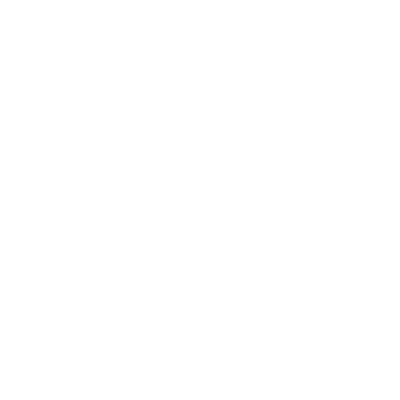

In [12]:
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

import random
for it in range(10000):
    #select_class = random.sample(range(0,len(img)),n_way)
    #for i in select_class:
    #    training_set, training_label = [], []
    #    index = random.sample(range(1, len(img[i])), n_shot)
    #    for j in index:
    #        training_set.append(img[i][j])
    #        training_label.append(lab[i][j])
        
    #    X ,c = np.asarray(training_set), np.asarray(training_label)
    X, c = mnist.train.next_batch(mb_size)

    X = Variable(torch.from_numpy(X))
    c = Variable(torch.from_numpy(c.astype('float32')))
    # Forward
    z_mu, z_var = Q(X, c)
    z = sample_z(z_mu, z_var)
    X_sample = P(z, c)
    # Loss
    recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    loss.backward()
    solver.step()
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    if it % 500 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.data[0]))

        c = np.zeros(shape=[mb_size, y_dim], dtype='float32')
        c[:, np.random.randint(0, 10)] = 1.
        print('now generating imgae with {}'.format(c[0].tolist().index(1.)))
        c = Variable(torch.from_numpy(c))
        z = Variable(torch.randn(mb_size, Z_dim))
        samples = P(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)

<IPython.core.display.Javascript object>


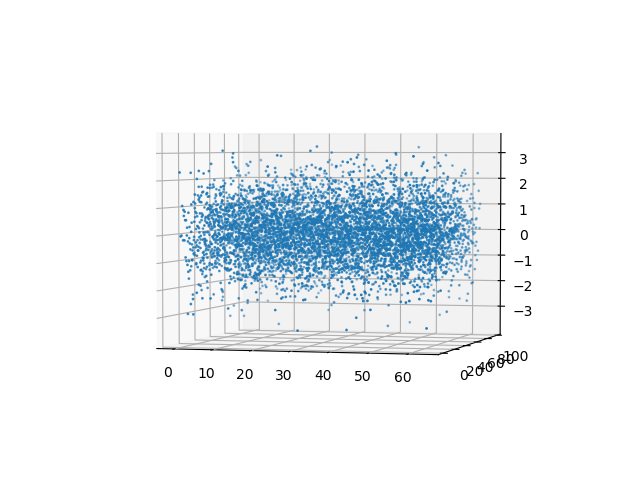

In [13]:
from mpl_toolkits.mplot3d import Axes3D
zz = z.data.numpy()
xx = []
yy = []
value = []
for i in range(zz.shape[0]):
    for j in range(zz.shape[1]):
        xx.append(i)
        yy.append(j)
        value.append(zz[i][j])

ax = plt.subplot(111, projection='3d')
ax.scatter(xx,yy,zz,s=1)
plt.show()

-2.4094708